### chromate

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

import torchvision
from torchvision import datasets, models
from torchvision import transforms

## 1. Data Visulization

In [3]:
base_path = "/content/drive/MyDrive/Colab Notebooks/DL/data/chromate/"

def load_images_from_folder(folder):

    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
        if len(images)>5:
            break

    plt.figure(figsize=(16,8))
    for img,x in zip(images,range(1,7)):
        plt.subplot(2,3,x)
        plt.imshow(img)

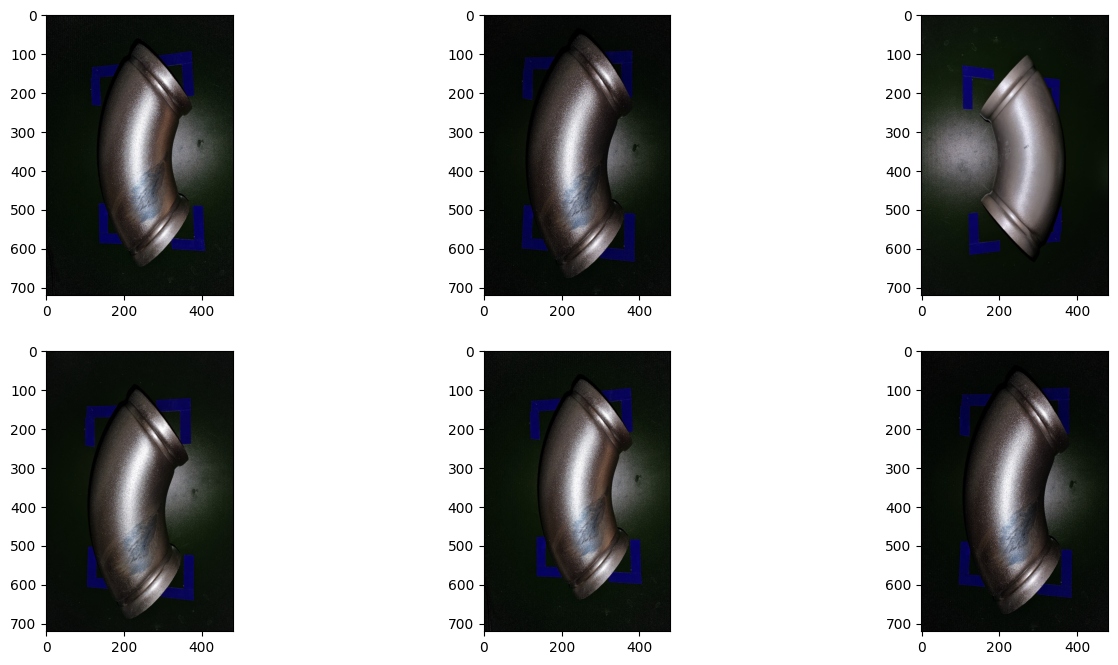

In [4]:
load_images_from_folder(base_path + "NG")

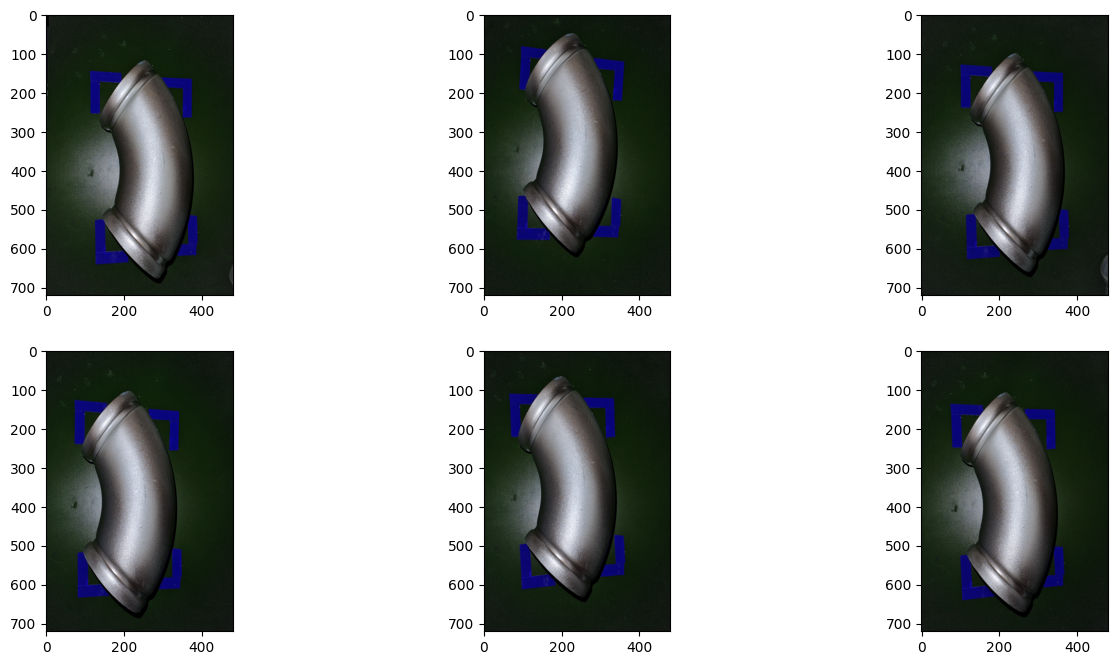

In [5]:
load_images_from_folder(base_path + "OK")

## 2. Data Processing

In [6]:
# Transforms에서 Data Augmentation, Tensor변환, Normalize 변환
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456,0.406],
        [0.229, 0.224, 0.225])])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225])])

In [7]:
# pip install split-folders
# NG와 OK 폴더를 train, val로 나눔
import splitfolders

splitfolders.ratio('/content/drive/MyDrive/Colab Notebooks/DL/data/chromate',
                   output='/content/drive/MyDrive/Colab Notebooks/DL/data/chromate/test', seed=37,ratio=(.8, .1, .1))

Copying files: 174 files [00:02, 81.86 files/s]


In [8]:
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/DL/data/chromate/test/train',
          transform=train_transforms)

val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/DL/data/chromate/test/val',
            transform=val_transforms)

test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/DL/data/chromate/test/test',
            transform=test_transforms)

In [20]:
print(train_dataset)
print(val_dataset)
print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 139
    Root location: /content/drive/MyDrive/Colab Notebooks/DL/data/chromate/test/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 17
    Root location: /content/drive/MyDrive/Colab Notebooks/DL/data/chromate/test/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 18
    Root location: /content/drive/MyDrive/Colab Notebook

In [24]:
train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=16,
            shuffle=True,
            num_workers=4)

val_loader = torch.utils.data.DataLoader(
            val_dataset,
            batch_size=16,
            shuffle=True,
            num_workers=4)

test_loader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=1,
            shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [22]:
_,classes=next(iter(test_loader))

In [23]:
classes

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
models.list_models()

In [ ]:
from efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained('efficientnet-b0')
num_ftrs=model._fc.in_features
model._fc=nn.Linear(num_ftrs, 4)
print(model)

In [ ]:
"""
model = models.efficientnet_b0(pretrained=True)
print(model.classifier)

num_ftrs = model.classifier.features
model.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=True),nn.Linear(num_ftrs, 4))
print(model.classifier)

https://pytorch.org/vision/main/_modules/torchvision/models/efficientnet.html#EfficientNet_B0_Weights
"""

## 4. Training

In [13]:
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=0.001,
                      momentum=0.9)

exp_lr_scheduler = StepLR(optimizer,
                          step_size=7,
                          gamma=0.1)

In [14]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [15]:
# early_stopping 객체 선언(3번의 epoch 연속으로 loss 미개선 시에 조기 종료 예시)
es = EarlyStopping(patience = 3, verbose = True, delta=0.001, path='/content/drive/MyDrive/Colab Notebooks/DL/data/chromate/chromate_resnet.pt')

num_epochs=10

for epoch in range(num_epochs):
  # Train
  model.train()
  running_loss = 0.0
  running_corrects = 0

  for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()/inputs.size(0)
        running_corrects += \
        torch.sum(preds == labels.data)/inputs.size(0)

  exp_lr_scheduler.step()
  train_epoch_loss = running_loss / len(train_loader)
  train_epoch_acc = running_corrects / len(train_loader)

 # Validation
  model.eval()
  running_loss = 0.0
  running_corrects = 0

  for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs,1)
      loss = criterion(outputs, labels)

      running_loss += loss.item()/inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)/inputs.size(0)

  epoch_loss = running_loss / len(val_loader)
  epoch_acc = running_corrects.double() / len(val_loader)

  es(-epoch_acc, model)
  if es.early_stop:
    print(epoch, loss.item())
    break
  print("Train: Loss: {:.4f} Acc: {:.4f}"
    " Val: Loss: {:.4f}"
    " Acc: {:.4f}".format(train_epoch_loss,
                         train_epoch_acc,
                         epoch_loss,
                         epoch_acc))

Validation loss decreased (inf --> -0.281250).  Saving model ...
Train: Loss: 0.0852 Acc: 0.4173 Val: Loss: 0.6523 Acc: 0.2812
Validation loss decreased (-0.281250 --> -0.781250).  Saving model ...
Train: Loss: 0.0661 Acc: 0.6888 Val: Loss: 0.5016 Acc: 0.7812
EarlyStopping counter: 1 out of 3
Train: Loss: 0.0519 Acc: 0.7128 Val: Loss: 0.3851 Acc: 0.7812
EarlyStopping counter: 2 out of 3
Train: Loss: 0.0408 Acc: 0.8409 Val: Loss: 0.3243 Acc: 0.7812
EarlyStopping counter: 3 out of 3
4 1.2715163230895996


## 5. Testing and Deployment

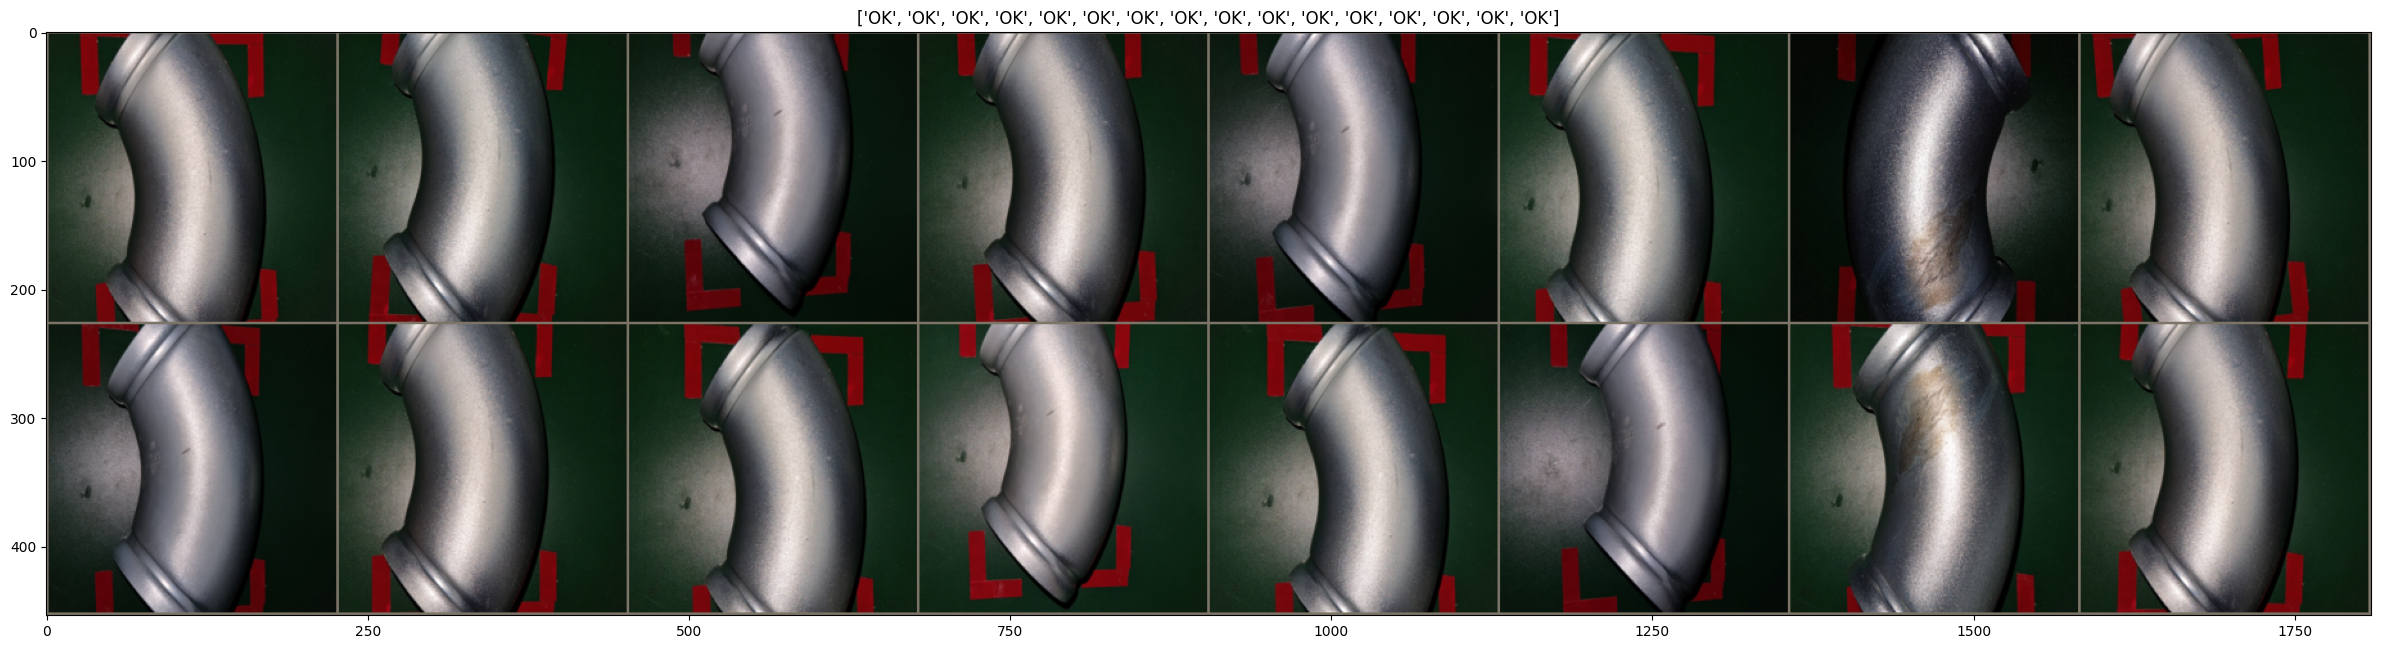

In [16]:
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.figure(figsize=[30, 30])
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

inputs, classes = next(iter(val_loader))
out = torchvision.utils.make_grid(inputs)
class_names = val_dataset.classes

outputs = model(inputs.to(device))
_, preds = torch.max(outputs,1)

imshow(out, title=[class_names[x] for x in preds])

metric

In [17]:
num_correct = 0.0
predicted_list = []
for x_test_batch, y_test_batch in test_loader:
    model.eval()
    y_test_batch = y_test_batch.to(device)
    x_test_batch = x_test_batch.to(device)

    y_pred_batch = model(x_test_batch)
    _, predicted = torch.max(y_pred_batch, 1)
    predicted_list.append(predicted.cpu().numpy())
    num_correct += (predicted == y_test_batch).float().sum()

accuracy = num_correct/(len(test_loader)*test_loader.batch_size)

print(len(test_loader), test_loader.batch_size)
print("Test Accuracy: {}".format(accuracy))

18 1
Test Accuracy: 0.5555555820465088


In [18]:
predicted_list

[array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1])]

In [25]:
# efficientnet
from sklearn.metrics import classification_report

print(classification_report(classes, predicted_list))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.56      1.00      0.71        10

    accuracy                           0.56        18
   macro avg       0.28      0.50      0.36        18
weighted avg       0.31      0.56      0.40        18



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
